# Reproduce old optimization
min_recipe CO2(recipe)
s.t. G(recipe) >10

where G(recipe) is a GP trained on simulated data from first cement hydration and second elastic moduli computation from hydrated cement

In [1]:
import pickle
from joblib import dump, load
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ml.opt import opt, opt_gp, opt_ismo

/tmp/ipykernel_2395586/2100846509.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Optimization using GP for the constraints

# get initial points for the optimization task
file_path = '/mnt/disk1/projects/Cement/02-Software_and_Models/Models/InputData/'
name = '_10_all_output_lower_bounds'
initial_points = pd.read_csv(file_path+ 'recipe_data'+name+'.csv',  index_col=[0])
initial_points

C3S        C2S        C3A       C4AF  RH   T  fineness        wc  \
0     60.086032  26.059775  12.064128   7.427653   1  25       385  0.419176   
1     65.472019  10.712615   4.720774  11.745447   1  25       385  0.564079   
2     72.874170  22.497137   9.256601   9.924277   1  25       385  0.613135   
3     51.567959   6.774976   7.538067  13.246861   1  25       385  0.370600   
4     45.311349  16.358730   5.923142  14.067801   1  25       385  0.327425   
...         ...        ...        ...        ...  ..  ..       ...       ...   
1018  45.290575  12.509947  13.762617  13.097229   1  25       385  0.359593   
1019  51.620618  26.121987   9.713631  14.213091   1  25       385  0.341416   
1020  72.826459  10.648835   7.057614  10.895051   1  25       385  0.699649   
1021  65.487553  22.434382  12.540708  12.716476   1  25       385  0.547926   
1022  60.065283   6.836230   4.259833   8.393644   1  25       385  0.493623   

          CSH2  limestone  silica_fume      GGBFS    fly_ash  calcined_clay  
0     2.191757   8.938177     8.938177   8.938177   8.938177       8.938177  
1     3.640789  19.805914    19.805914  19.805914  19.805914      19.805914  
2     4.131354  23.485158    23.485158  23.485158  23.485158      23.485158  
3     1.705997   5.294980     5.294980   5.294980   5.294980       5.294980  
4     1.274251   2.056886     2.056886   2.056886   2.056886       2.056886  
...        ...        ...          ...        ...        ...            ...  
1018  1.595935   4.469509     4.469509   4.469509   4.469509       4.469509  
1019  1.414159   3.106191     3.106191   3.106191   3.106191       3.106191  
1020  4.996491  29.973680    29.973680  29.973680  29.973680      29.973680  
1021  3.479260  18.594448    18.594448  18.594448  18.594448      18.594448  
1022  2.936226  14.521698    14.521698  14.521698  14.521698      14.521698  

[1023 rows x 14 columns]

In [3]:
initial_points = initial_points.iloc[0:10,:]
initial_points

C3S        C2S        C3A       C4AF  RH   T  fineness        wc  \
0  60.086032  26.059775  12.064128   7.427653   1  25       385  0.419176   
1  65.472019  10.712615   4.720774  11.745447   1  25       385  0.564079   
2  72.874170  22.497137   9.256601   9.924277   1  25       385  0.613135   
3  51.567959   6.774976   7.538067  13.246861   1  25       385  0.370600   
4  45.311349  16.358730   5.923142  14.067801   1  25       385  0.327425   
5  79.135874   0.886554  13.266545  10.761540   1  25       385  0.682485   
6  67.960338  28.171334   8.760014  12.565379   1  25       385  0.533795   
7  57.592660  12.574159  10.478502   8.262018   1  25       385  0.476415   
8  55.126364  21.739076   7.926188  10.107279   1  25       385  0.586055   
9  69.332813   5.015938  11.207042  14.784569   1  25       385  0.428639   

       CSH2  limestone  silica_fume      GGBFS    fly_ash  calcined_clay  
0  2.191757   8.938177     8.938177   8.938177   8.938177       8.938177  
1  3.640789  19.805914    19.805914  19.805914  19.805914      19.805914  
2  4.131354  23.485158    23.485158  23.485158  23.485158      23.485158  
3  1.705997   5.294980     5.294980   5.294980   5.294980       5.294980  
4  1.274251   2.056886     2.056886   2.056886   2.056886       2.056886  
5  4.824846  28.686342    28.686342  28.686342  28.686342      28.686342  
6  3.337949  17.534617    17.534617  17.534617  17.534617      17.534617  
7  2.764154  13.231158    13.231158  13.231158  13.231158      13.231158  
8  3.860548  21.454110    21.454110  21.454110  21.454110      21.454110  
9  2.286386   9.647893     9.647893   9.647893   9.647893       9.647893

In [124]:
emission_dic ={#'opc' : 0.74, #CH market ecoinven, 0.84t worldwide average in ton of CO2 (0.73-0.85)
            'C3S':0.74,
            'C2S':0.74,
            'C3A':0.74,
            'C4AF':0.74,
          'fly_ash' : 0.004,# values from Alsalaman + al
          'CSH2': 0.0082, # RER market ecoinvent
          'silica_fume' : 0.0035, # GLO market ecoinvent 
          'GGBFS' : 0.13, # ROW market ecoinvent
          'limestone': 0.0023, # CH market #0.00313,  #value from A Review of Carbon Footprint Reduction in Construction Industry, from Design to Operation  Sizirici + al
          'calcined_clay': 0.27, # ROW market #0.196, #best value from Limestone calcined clay cement as a low-carbon solution to meet expanding cement demand in emerging economies, Yudiesky + al.
}

In [125]:
def CO2_emission(data):
    
    # Filter data to only those ingredients that have emission factors
    filtered_data = data.loc[:,emission_dic.keys()]

    # Compute total CO2 emissions per column
    co2_emissions = (filtered_data * pd.Series(emission_dic)).sum(axis = 1)

    # Compute total material weights per column
    material_weights = filtered_data.sum(axis = 1)

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        co2_per_kg = co2_emissions / material_weights
        co2_per_kg[material_weights == 0] = np.nan  # Handle division by zero if any

    # Creating the final DataFrame
    total_CO2_emissions = pd.DataFrame({
        #'CO2': co2_emissions,
        #'weight': material_weights,
        'CO2_per_kg': co2_per_kg
    })

    return total_CO2_emissions


In [6]:
# optimization
model_path = '/mnt/disk1/projects/Cement/02-Software_and_Models/Models/Output/Models/'+ 'GPG'+name+'.joblib'

elastic_model = load(model_path)


In [7]:
pred = elastic_model.predict(initial_points)
pred

array([[19.37736879,  9.01624686, 23.41681052,  0.2985897 ],
       [16.2405732 ,  7.66563209, 19.87056136,  0.29608108],
       [14.20079062,  6.89788937, 17.80999376,  0.29097415],
       [31.76190085, 13.1851947 , 34.74780664,  0.3177185 ],
       [35.67278765, 14.76075148, 38.91483691,  0.31818617],
       [13.38295448,  6.56901445, 16.93603023,  0.28908456],
       [15.69304191,  7.48293459, 19.37005402,  0.29428193],
       [18.51060301,  8.65206162, 22.45726046,  0.29779823],
       [15.06237682,  7.32327859, 18.90584844,  0.29080495],
       [19.85702813,  9.10275463, 23.68853868,  0.30117419]])

In [8]:
initial_points.columns

Index(['C3S', 'C2S', 'C3A', 'C4AF', 'RH', 'T', 'fineness', 'wc', 'CSH2',
       'limestone', 'silica_fume', 'GGBFS', 'fly_ash', 'calcined_clay'],
      dtype='object')

In [9]:
from scipy.optimize import Bounds
from scipy.optimize import BFGS
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import minimize


In [148]:
emission_dic ={'opc' : 0.85, # in ton of CO2
          'fly_ash' : 0.004,# values from Alsalaman + al
          'silica_fume' : 0.014, 
          'GGBFS' : 0.052,
          'metakolain' : 0.33,
          'fine_aggregate' :0.0048,
          'coarse_aggregate':0.0048,
          'admixture': 1.88,
          'sodium_hydroxide': 1.915,
          'sodium_silicate': 1.222,
          'limestone': 0.00313,  #value from A Review of Carbon Footprint Reduction in Construction Industry, from Design to Operation  Sizirici + al
          'calcined_clay': 0.196, #best value from Limestone calcined clay cement as a low-carbon solution to meet expanding cement demand in emerging economies, Yudiesky + al.
          'pozzolan': 0.00313, #value not found (so same as limestone as there are both existing in natural state
}

def co2_emission_fct(recipe_dic):
    ''' Function to compute the CO2 emission of a given recipe'''
    co2_emission = 100*emission_dic['opc']
    material_mass = 100
    for i in ['limestone', 'silica_fume', 'GGBFS', 'fly_ash', 'calcined_clay']:
        switch={'limestone': recipe_dic[-5],
                'silica_fume':recipe_dic[-4],
                'GGBFS':recipe_dic[-3],
                'fly_ash':recipe_dic[-2],
                'calcined_clay': recipe_dic[-1],
                }
        mass = switch.get(i)
        co2_emission += emission_dic[i]* mass
        material_mass += mass
    return co2_emission/material_mass


In [11]:
def opt_gp2(b_b_function, c_function, x, initial_point = None):
    ''' Standard optimization function '''
    def fun(x):
        return co2_emission_fct(x)
    def con(x):

        x1 = x.reshape(1,-1)
        x1 = pd.DataFrame(x1, columns = ['C3S', 'C2S', 'C3A', 'C4AF', 'RH', 'T', 'fineness', 'wc', 'CSH2',
       'limestone', 'silica_fume', 'GGBFS', 'fly_ash', 'calcined_clay'])
        
        return c_function.predict(x1)[0][1]
    print('Initialization of the constraints')
    bounds = Bounds([45, 10, 0, 0, 1, 25, 385, 0.3, 4, 0, 0, 0, 0, 0] , [80, 32, 14, 15, 1, 25, 385, 0.7, 4, 20, 10, 35, 35, 35])
    m = [[1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
    v = [100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    linear_constraint = LinearConstraint(m,v,v)
    nonlinear_constraint = NonlinearConstraint(con, 10, np.inf, jac='2-point', hess=BFGS())
    min_dic = {}
    for i in range(x.shape[0]):
        print(f'Begining of the {i}th iteration') 
        x1 = x.to_numpy()
        x0 = x1[i,:]
        res = minimize(fun, x0, method='trust-constr', jac='2-point', hess=BFGS(),
               constraints=[linear_constraint, nonlinear_constraint],
               options={'verbose': 0}, bounds=bounds, tol = 1e-2)
        min_dic[f'Iteration {i}'] = {'recipe': res.x, 'co2_value': res.fun}
        print(f'Result for the {i}th iteration: {res.x} with CO2 emissions of {res.fun}' )
    return min_dic

In [12]:
# Look for the minimal value of the above algorithm
min_list_gp_old = min_list_gp
min_list_gp_old = pd.DataFrame(min_list_gp_old)
co2_value= 100 #set initial co2 value unrealistically high
min_recipe = []

for value, key in enumerate(min_list_gp):
    if min_list_gp[key]['co2_value'] < co2_value:
        co2_value = min_list_gp[key]['co2_value']
        min_recipe = min_list_gp[key]['recipe']
print(f'The best recipe is {min_recipe} with CO2 emissions of {co2_value}')

pd.DataFrame(min_recipe, index =initial_points.columns.to_list()) 

NameError: name 'min_list_gp' is not defined

In [13]:
#co2_emission_fct(x)
def elasticity(x):
    x1 = x.reshape(1,-1)
    x1 = pd.DataFrame(x1, columns = ['C3S', 'C2S', 'C3A', 'C4AF', 'RH', 'T', 'fineness', 'wc', 'CSH2',
       'limestone', 'silica_fume', 'GGBFS', 'fly_ash', 'calcined_clay'])
  
    return elastic_model.predict(x1)




In [14]:
from pymoo.core.problem import ElementwiseProblem


In [15]:
initial_points

C3S        C2S        C3A       C4AF  RH   T  fineness        wc  \
0  60.086032  26.059775  12.064128   7.427653   1  25       385  0.419176   
1  65.472019  10.712615   4.720774  11.745447   1  25       385  0.564079   
2  72.874170  22.497137   9.256601   9.924277   1  25       385  0.613135   
3  51.567959   6.774976   7.538067  13.246861   1  25       385  0.370600   
4  45.311349  16.358730   5.923142  14.067801   1  25       385  0.327425   
5  79.135874   0.886554  13.266545  10.761540   1  25       385  0.682485   
6  67.960338  28.171334   8.760014  12.565379   1  25       385  0.533795   
7  57.592660  12.574159  10.478502   8.262018   1  25       385  0.476415   
8  55.126364  21.739076   7.926188  10.107279   1  25       385  0.586055   
9  69.332813   5.015938  11.207042  14.784569   1  25       385  0.428639   

       CSH2  limestone  silica_fume      GGBFS    fly_ash  calcined_clay  
0  2.191757   8.938177     8.938177   8.938177   8.938177       8.938177  
1  3.640789  19.805914    19.805914  19.805914  19.805914      19.805914  
2  4.131354  23.485158    23.485158  23.485158  23.485158      23.485158  
3  1.705997   5.294980     5.294980   5.294980   5.294980       5.294980  
4  1.274251   2.056886     2.056886   2.056886   2.056886       2.056886  
5  4.824846  28.686342    28.686342  28.686342  28.686342      28.686342  
6  3.337949  17.534617    17.534617  17.534617  17.534617      17.534617  
7  2.764154  13.231158    13.231158  13.231158  13.231158      13.231158  
8  3.860548  21.454110    21.454110  21.454110  21.454110      21.454110  
9  2.286386   9.647893     9.647893   9.647893   9.647893       9.647893

In [70]:
# Implement the Multiobjective Optimization Problem:
'''
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var = 14, 
                        n_obj = 2, 
                        n_ieq_constr = 4, 
                        n_eq_constr = 1, 
                        xl = [45, 10, 0, 0, 1, 25, 385, 0.3, 4, 0, 0, 0, 0, 0], 
                        xu = [80, 32, 14, 15, 1, 25, 385, 0.7, 4, 20, 10, 35, 35, 35])

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = co2_emission_fct(x)
        f2 = -np.linalg.norm(elasticity(x))
        g1 = 10 - elasticity(x)[0][0]
        g2 = 5 - elasticity(x)[0][1]
        g3 = 10 - elasticity(x)[0][2]
        g4 = 0.15 - elasticity(x)[0][3]
      #  h1 = 100- x[0]+x[1]+x[2]+x[3]
        #h1 = x[0]-50
        out["F"] = [f1,f2]
        out["G"] = [g1,g2,g3,g4]
       # out["H"] = [h1]
problem = MyProblem()        '''

'\nclass MyProblem(ElementwiseProblem):\n\n    def __init__(self):\n        super().__init__(n_var = 14, \n                        n_obj = 2, \n                        n_ieq_constr = 4, \n                        n_eq_constr = 1, \n                        xl = [45, 0, 4, 7, 1, 25, 385, 0.3, 1, 0, 0, 0, 0, 0], \n                        xu = [80, 32, 14, 15, 1, 25, 385, 2, 5, 30, 30, 30, 30, 30])\n\n    def _evaluate(self, x, out, *args, **kwargs):\n        f1 = co2_emission_fct(x)\n        f2 = -np.linalg.norm(elasticity(x))\n        g1 = 10 - elasticity(x)[0][0]\n        g2 = 5 - elasticity(x)[0][1]\n        g3 = 10 - elasticity(x)[0][2]\n        g4 = 0.15 - elasticity(x)[0][3]\n      #  h1 = 100- x[0]+x[1]+x[2]+x[3]\n        #h1 = x[0]-50\n        out["F"] = [f1,f2]\n        out["G"] = [g1,g2,g3,g4]\n       # out["H"] = [h1]\nproblem = MyProblem()        '

In [266]:
# Implement the Multiobjective Optimization Problem:
class MyProblem1(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var = 14, 
                        n_obj = 2, 
                        n_ieq_constr = 4, 
                        n_eq_constr = 1, 
                        xl = [45, 10, 0, 0, 1, 25, 385, 0.3, 4, 0, 0, 0, 0, 0], 
                        xu = [80, 32, 14, 15, 1, 25, 385, 0.7, 4, 20, 10, 35, 35, 35])

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = co2_emission_fct(x)  # minimize CO2

        f2 = -elasticity(x)[0][0]   # maximize the bulk modulus
        
        g1 = 10 - elasticity(x)[0][0]   # bulk modulus should be higher than a certain amount to ensue that the compressive strength has a certain value
        g2 = x[9]+x[10]+x[11]+x[12]+x[13]-100  # sum of SCM should be smaller than 0 
        h1 = 100- (x[0]+x[1]+x[2]+x[3]+x[8])  # sum of all cement ingredients should add up to 100
        
        out["F"] = [f1,f2]
        out["G"] = [g1,g2]
        out["H"] = [h1]
problem = MyProblem1()        

In [267]:
#Initialize an Algorithm
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)



In [268]:
# Define a Termination Criterion
from pymoo.termination import get_termination

termination = get_termination("n_gen", 1000)

In [269]:
# Optimize
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F



n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  1.2447624114 |  1.321842E+01 |             - |             -
     2 |      110 |      1 |  1.2447624114 |  1.153450E+01 |             - |             -
     3 |      120 |      1 |  1.2447624114 |  9.9142965628 |             - |             -
     4 |      130 |      1 |  1.2447624114 |  8.7687469458 |             - |             -
     5 |      140 |      1 |  1.2447624114 |  8.1780290171 |             - |             -
     6 |      150 |      1 |  1.2447624114 |  7.4742640136 |             - |             -
     7 |      160 |      1 |  1.2447624114 |  6.7372367433 |             - |             -
     8 |      170 |      1 |  1.2447624114 |  5.9807000467 |             - |             -
     9 |      180 |      1 |  1.2447624114 |  5.7326282428 |             - |             -
    10 |      190 |      1 |  1.2447624114 |  5.1012846133 |             - |             -

In [270]:
res.X

array([[6.26033635e+01, 2.35335204e+01, 6.58803244e+00, ...,
        1.52125570e+01, 1.50367131e-05, 3.51077896e-03],
       [6.26033660e+01, 2.35335212e+01, 6.58803518e+00, ...,
        2.99994535e+01, 1.63433556e+01, 4.96665191e-02],
       [6.26033634e+01, 2.35335204e+01, 6.58803215e+00, ...,
        1.84005058e+01, 1.07839563e-03, 3.51077896e-03],
       ...,
       [6.26033638e+01, 2.35335204e+01, 6.58810971e+00, ...,
        2.99906413e+01, 3.26880313e+00, 1.85330635e-02],
       [6.26033637e+01, 2.35335203e+01, 6.58804020e+00, ...,
        2.99936337e+01, 1.10736389e+01, 6.64692990e-03],
       [6.26033634e+01, 2.35335203e+01, 6.58805549e+00, ...,
        2.99619737e+01, 1.22645475e+01, 2.06629712e-03]])

In [271]:
X

array([[6.26033635e+01, 2.35335204e+01, 6.58803244e+00, ...,
        1.52125570e+01, 1.50367131e-05, 3.51077896e-03],
       [6.26033660e+01, 2.35335212e+01, 6.58803518e+00, ...,
        2.99994535e+01, 1.63433556e+01, 4.96665191e-02],
       [6.26033634e+01, 2.35335204e+01, 6.58803215e+00, ...,
        1.84005058e+01, 1.07839563e-03, 3.51077896e-03],
       ...,
       [6.26033638e+01, 2.35335204e+01, 6.58810971e+00, ...,
        2.99906413e+01, 3.26880313e+00, 1.85330635e-02],
       [6.26033637e+01, 2.35335203e+01, 6.58804020e+00, ...,
        2.99936337e+01, 1.10736389e+01, 6.64692990e-03],
       [6.26033634e+01, 2.35335203e+01, 6.58805549e+00, ...,
        2.99619737e+01, 1.22645475e+01, 2.06629712e-03]])

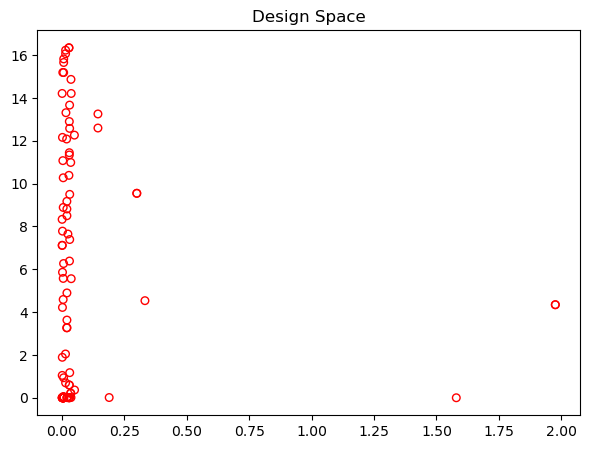

In [272]:
# Visualize
import matplotlib.pyplot as plt
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 10], X[:, 12], s=30, facecolors='none', edgecolors='r')
#plt.xlim(xl[0], xu[0])
#plt.ylim(xl[1], xu[1])
plt.title("Design Space")
plt.show()



In [273]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.xlabel('kg CO2 equivalents')
plt.ylabel('negative squared sum of elastic moduli')



Text(0, 0.5, 'negative squared sum of elastic moduli')

In [274]:
X[:,3]

array([7.27505348, 7.27505304, 7.27505283, 7.27505308, 7.27505309,
       7.27505384, 7.27505308, 7.27505929, 7.27505246, 7.27505443,
       7.27505294, 7.27505377, 7.27505246, 7.27505436, 7.27505298,
       7.27505428, 7.27505436, 7.275054  , 7.27505371, 7.27505443,
       7.27505397, 7.27506013, 7.27505318, 7.27505324, 7.275059  ,
       7.27505384, 7.27505347, 7.27505441, 7.27505304, 7.27505324,
       7.27505448, 7.27505904, 7.27505307, 7.27505367, 7.27505314,
       7.27505398, 7.27505374, 7.27505914, 7.27505915, 7.275053  ,
       7.27505441, 7.275054  , 7.27505929, 7.27505324, 7.27505441,
       7.27505393, 7.27505385, 7.27505371, 7.27505446, 7.27505246,
       7.2750541 , 7.27505446, 7.2750537 , 7.27505971, 7.27505454,
       7.27505296, 7.2750537 , 7.2750537 , 7.27505294, 7.27505874,
       7.27505905, 7.27505431, 7.27505313, 7.2750537 , 7.27505393,
       7.27505348, 7.27505431, 7.27505468, 7.27505372, 7.27505898,
       7.27505881, 7.27505443, 7.275054  , 7.27505314, 7.27505

In [275]:
el_list = []
CO2_list = []
for el in X:
    print(el)
    el_list.append(elasticity(el))
    CO2_list.append(co2_emission_fct((el)))

[6.26033635e+01 2.35335204e+01 6.58803244e+00 7.27505348e+00
 1.00000000e+00 2.50000000e+01 3.85000000e+02 6.85209753e-01
 1.01583939e+00 6.12933703e-03 3.57665941e-03 1.52125570e+01
 1.50367131e-05 3.51077896e-03]
[6.26033660e+01 2.35335212e+01 6.58803518e+00 7.27505304e+00
 1.00000000e+00 2.50000000e+01 3.85000000e+02 6.62060024e-01
 1.50367310e+00 2.06009057e-01 2.84532017e-02 2.99994535e+01
 1.63433556e+01 4.96665191e-02]
[6.26033634e+01 2.35335204e+01 6.58803215e+00 7.27505283e+00
 1.00000000e+00 2.50000000e+01 3.85000000e+02 6.80430784e-01
 1.08151275e+00 6.12427896e-03 1.72659403e-03 1.84005058e+01
 1.07839563e-03 3.51077896e-03]
[6.26033661e+01 2.35335212e+01 6.58803160e+00 7.27505308e+00
 1.00000000e+00 2.50000000e+01 3.85000000e+02 6.61828096e-01
 1.44689742e+00 7.39828089e-04 2.76121972e-02 2.62382617e+01
 7.41730170e-04 2.07087946e-02]
[6.26033660e+01 2.35335204e+01 6.58804163e+00 7.27505309e+00
 1.00000000e+00 2.50000000e+01 3.85000000e+02 6.61795586e-01
 1.50717518e+00 7.

In [276]:
el_list

[array([[26.2126458 , 11.52929442, 30.15511836,  0.30550136]]),
 array([[22.50870523, 10.00070475, 26.11811046,  0.30017117]]),
 array([[26.22457726, 11.49024874, 30.06621066,  0.30540205]]),
 array([[25.98217728, 11.32053962, 29.63972246,  0.30412265]]),
 array([[23.47871572, 10.36790775, 27.09859691,  0.30138269]]),
 array([[26.22041759, 11.50200089, 30.09292774,  0.30545636]]),
 array([[25.385265  , 11.07477368, 28.99019135,  0.30288213]]),
 array([[26.20899429, 11.47417475, 30.02684286,  0.30532854]]),
 array([[26.21409716, 11.50718793, 30.10411537,  0.30547394]]),
 array([[25.91242841, 11.2831078 , 29.54341173,  0.30373732]]),
 array([[24.56538273, 10.7727345 , 28.18135607,  0.30233079]]),
 array([[25.7894856 , 11.22268597, 29.38659204,  0.30311193]]),
 array([[25.82001737, 11.23680655, 29.42346646,  0.30324587]]),
 array([[25.70459982, 11.19066042, 29.30108119,  0.30302449]]),
 array([[25.44464481, 11.09574126, 29.04663375,  0.30288522]]),
 array([[26.14366686, 11.41268741, 29.87

In [277]:
CO2_list

[0.7445538997833627,
 0.5908608885824542,
 0.7259135513574306,
 0.6839034307283669,
 0.6166710232711647,
 0.7317107915160407,
 0.6586417245306095,
 0.7209235695598664,
 0.7349659998887411,
 0.6767316878716935,
 0.6415095058387403,
 0.6666763904718418,
 0.6685812771772784,
 0.6645485910659973,
 0.659794204179025,
 0.702492932373415,
 0.6612117742896845,
 0.7404557727655041,
 0.63479296456123,
 0.6263791731359362,
 0.5967383911414823,
 0.628100256887982,
 0.6799263549423081,
 0.6469996825705531,
 0.602734868989939,
 0.656395186541588,
 0.6872750189308721,
 0.613958881346784,
 0.6728851193972795,
 0.6434545808007097,
 0.6207187410120729,
 0.6531656507593281,
 0.6450210866202872,
 0.6369153681111362,
 0.71570345728033,
 0.700834529697883,
 0.621846358326239,
 0.7075583473515773,
 0.7129915948141305,
 0.6409026078533246,
 0.6114921291412292,
 0.6719407342632064,
 0.7188085136006809,
 0.69382098816497,
 0.6126130558221039,
 0.6040272503491264,
 0.6181760163101299,
 0.6361446682661887,
 0.630

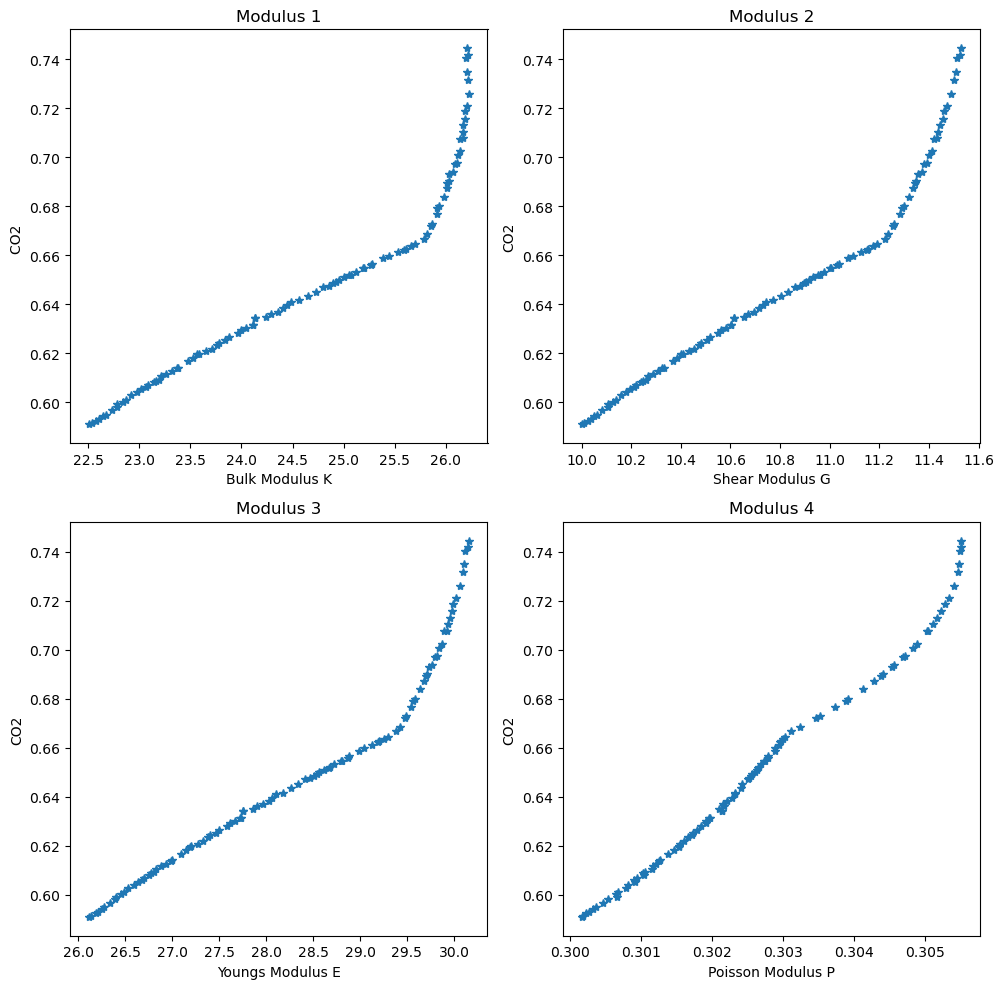

In [278]:


all_data = np.vstack(el_list)

# Separate data into individual moduli
modulus_1 = all_data[:, 0]
modulus_2 = all_data[:, 1]
modulus_3 = all_data[:, 2]
modulus_4 = all_data[:, 3]




# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Adjust the size as needed

# Plot each modulus
axs[0,0].plot(modulus_1,CO2_list,'*')
axs[0,0].set_title('Modulus 1')
axs[0,0].set_ylabel('CO2 ')
axs[0,0].set_xlabel('Bulk Modulus K')

axs[0,1].plot(modulus_2,CO2_list,'*')
axs[0,1].set_title('Modulus 2')
axs[0,1].set_ylabel('CO2')
axs[0,1].set_xlabel('Shear Modulus G')

axs[1,0].plot(modulus_3,CO2_list,'*')
axs[1,0].set_title('Modulus 3')
axs[1,0].set_ylabel('CO2')
axs[1,0].set_xlabel('Youngs Modulus E')

axs[1,1].plot(modulus_4,CO2_list,'*')
axs[1,1].set_title('Modulus 4')
axs[1,1].set_ylabel('CO2')
axs[1,1].set_xlabel('Poisson Modulus P')


# Improve layout to avoid overlap and show the plot
plt.tight_layout()
plt.show()

In [279]:
X1 = pd.DataFrame(X, columns = ['C3S', 'C2S', 'C3A', 'C4AF', 'RH', 'T', 'fineness', 'wc', 'CSH2',
       'limestone', 'silica_fume', 'GGBFS', 'fly_ash', 'calcined_clay'])
X1['CO2']= CO2_list
X1['K']=modulus_1
X1['G']=modulus_2
X1['E']=modulus_3
X1['P']=modulus_4

In [280]:
X1

C3S        C2S       C3A      C4AF   RH     T  fineness        wc  \
0   62.603364  23.533520  6.588032  7.275053  1.0  25.0     385.0  0.685210   
1   62.603366  23.533521  6.588035  7.275053  1.0  25.0     385.0  0.662060   
2   62.603363  23.533520  6.588032  7.275053  1.0  25.0     385.0  0.680431   
3   62.603366  23.533521  6.588032  7.275053  1.0  25.0     385.0  0.661828   
4   62.603366  23.533520  6.588042  7.275053  1.0  25.0     385.0  0.661796   
..        ...        ...       ...       ...  ...   ...       ...       ...   
95  62.603364  23.533520  6.588031  7.275054  1.0  25.0     385.0  0.680730   
96  62.603363  23.533520  6.588031  7.275053  1.0  25.0     385.0  0.630930   
97  62.603364  23.533520  6.588110  7.275053  1.0  25.0     385.0  0.670577   
98  62.603364  23.533520  6.588040  7.275054  1.0  25.0     385.0  0.674702   
99  62.603363  23.533520  6.588055  7.275054  1.0  25.0     385.0  0.618924   

        CSH2  limestone  silica_fume      GGBFS    fly_ash  calcined_clay  \
0   1.015839   0.006129     0.003577  15.212557   0.000015       0.003511   
1   1.503673   0.206009     0.028453  29.999454  16.343356       0.049667   
2   1.081513   0.006124     0.001727  18.400506   0.001078       0.003511   
3   1.446897   0.000740     0.027612  26.238262   0.000742       0.020709   
4   1.507175   0.000715     0.028340  29.983549  10.387092       0.049130   
..       ...        ...          ...        ...        ...            ...   
95  1.354736   0.067227     0.037370  29.984452   5.560785       0.016092   
96  1.256725   0.011752     0.001345  29.995269   7.117532       0.031561   
97  1.358847   0.087383     0.019255  29.990641   3.268803       0.018533   
98  1.834108   0.004508     0.003955  29.993634  11.073639       0.006647   
99  1.886457   0.008335     0.050201  29.961974  12.264548       0.002066   

         CO2          K          G          E         P  
0   0.744554  26.212646  11.529294  30.155118  0.305501  
1   0.590861  22.508705  10.000705  26.118110  0.300171  
2   0.725914  26.224577  11.490249  30.066211  0.305402  
3   0.683903  25.982177  11.320540  29.639722  0.304123  
4   0.616671  23.478716  10.367908  27.098597  0.301383  
..       ...        ...        ...        ...       ...  
95  0.638225  24.410842  10.715434  28.028023  0.302211  
96  0.631351  24.108164  10.602953  27.727101  0.301962  
97  0.649076  24.926733  10.905669  28.537412  0.302567  
98  0.613864  23.365617  10.325194  26.984527  0.301254  
99  0.608686  23.158062  10.247200  26.776107  0.301031  

[100 rows x 19 columns]

In [281]:
X1.sort_values('CO2')

C3S        C2S       C3A      C4AF   RH     T  fineness        wc  \
1   62.603366  23.533521  6.588035  7.275053  1.0  25.0     385.0  0.662060   
85  62.603366  23.533520  6.588035  7.275053  1.0  25.0     385.0  0.662576   
73  62.603363  23.533520  6.588031  7.275053  1.0  25.0     385.0  0.659868   
75  62.603363  23.533520  6.588042  7.275053  1.0  25.0     385.0  0.660129   
82  62.603366  23.533520  6.588132  7.275054  1.0  25.0     385.0  0.655816   
..        ...        ...       ...       ...  ...   ...       ...       ...   
5   62.603366  23.533521  6.588032  7.275054  1.0  25.0     385.0  0.636987   
8   62.603363  23.533521  6.588031  7.275052  1.0  25.0     385.0  0.674213   
17  62.603366  23.533520  6.588032  7.275054  1.0  25.0     385.0  0.637513   
65  62.603364  23.533520  6.588032  7.275053  1.0  25.0     385.0  0.685341   
0   62.603364  23.533520  6.588032  7.275053  1.0  25.0     385.0  0.685210   

        CSH2  limestone  silica_fume      GGBFS    fly_ash  calcined_clay  \
1   1.503673   0.206009     0.028453  29.999454  16.343356       0.049667   
85  1.503673   0.103703     0.028453  29.999275  16.343356       0.050015   
73  1.342499   0.003838     0.014957  29.967415  16.231694       0.052179   
75  1.400679   0.004020     0.014957  29.967415  16.067326       0.016007   
82  1.414044   0.001311     0.007386  29.924843  15.823660       0.019599   
..       ...        ...          ...        ...        ...            ...   
5   1.079872   0.003597     0.007235  17.374403   0.001059       0.020101   
8   1.185355   0.000772     0.004095  16.815185   0.000421       0.028527   
17  1.418262   0.003626     0.006959  15.883283   0.001098       0.020107   
65  1.000227   0.007881     0.003556  15.661174   0.000015       0.002425   
0   1.015839   0.006129     0.003577  15.212557   0.000015       0.003511   

         CO2          K          G          E         P  
1   0.590861  22.508705  10.000705  26.118110  0.300171  
85  0.591271  22.531245  10.008888  26.140071  0.300182  
73  0.592286  22.577818  10.026273  26.186573  0.300231  
75  0.593045  22.606960  10.037299  26.216018  0.300269  
82  0.594219  22.644851  10.051938  26.255020  0.300335  
..       ...        ...        ...        ...       ...  
5   0.731711  26.220418  11.502001  30.092928  0.305456  
8   0.734966  26.214097  11.507188  30.104115  0.305474  
17  0.740456  26.199210  11.514685  30.119503  0.305486  
65  0.741862  26.218715  11.525000  30.145990  0.305503  
0   0.744554  26.212646  11.529294  30.155118  0.305501  

[100 rows x 19 columns]

In [282]:
dir(res)

['CV',
 'F',
 'G',
 'H',
 'X',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'algorithm',
 'archive',
 'cv',
 'end_time',
 'exec_time',
 'f',
 'feas',
 'history',
 'message',
 'opt',
 'pf',
 'pop',
 'problem',
 'start_time',
 'success']

In [283]:
res.G

array([[-1.62126458e+01, -1.52929442e+00, -2.01551184e+01,
        -1.55501356e-01],
       [-1.25087052e+01, -7.04745046e-04, -1.61181105e+01,
        -1.50171170e-01],
       [-1.62245773e+01, -1.49024874e+00, -2.00662107e+01,
        -1.55402055e-01],
       [-1.59821773e+01, -1.32053962e+00, -1.96397225e+01,
        -1.54122646e-01],
       [-1.34787157e+01, -3.67907745e-01, -1.70985969e+01,
        -1.51382686e-01],
       [-1.62204176e+01, -1.50200089e+00, -2.00929277e+01,
        -1.55456365e-01],
       [-1.53852650e+01, -1.07477368e+00, -1.89901913e+01,
        -1.52882134e-01],
       [-1.62089943e+01, -1.47417475e+00, -2.00268429e+01,
        -1.55328543e-01],
       [-1.62140972e+01, -1.50718793e+00, -2.01041154e+01,
        -1.55473940e-01],
       [-1.59124284e+01, -1.28310780e+00, -1.95434117e+01,
        -1.53737315e-01],
       [-1.45653827e+01, -7.72734502e-01, -1.81813561e+01,
        -1.52330785e-01],
       [-1.57894856e+01, -1.22268597e+00, -1.93865920e+01,
      

In [284]:
res.CV

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [285]:
fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")


Scale f1: [590.8608885824542, 744.5538997833627]
Scale f2: [-41.58667965239494, -35.90127717992718]


In [286]:
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)



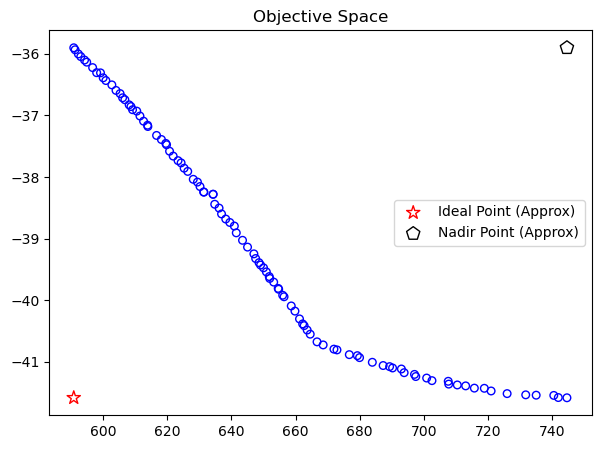

In [287]:


plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(approx_ideal[0], approx_ideal[1], facecolors='none', edgecolors='red', marker="*", s=100, label="Ideal Point (Approx)")
plt.scatter(approx_nadir[0], approx_nadir[1], facecolors='none', edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
plt.title("Objective Space")
plt.legend()
plt.show()



Scale f1: [0.0, 1.0]
Scale f2: [0.0, 1.0]


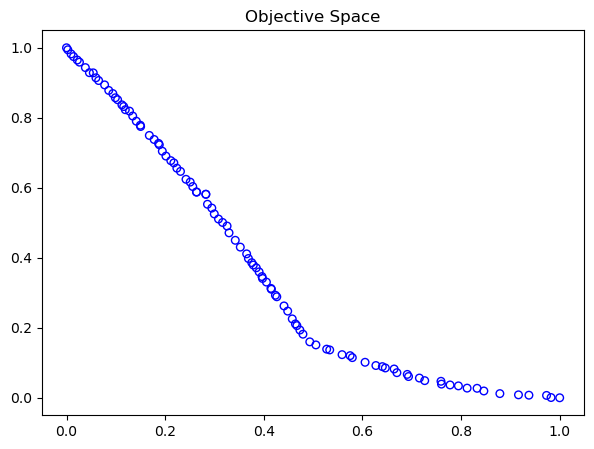

In [288]:
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)

fl = nF.min(axis=0)
fu = nF.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")

plt.figure(figsize=(7, 5))
plt.scatter(nF[:, 0], nF[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()



In [289]:
#Compromise Programming

In [290]:
weights = np.array([0.2, 0.8])

In [291]:
from pymoo.decomposition.asf import ASF

decomp = ASF()

In [292]:
i = decomp.do(nF, 1/weights).argmin()

Best regarding ASF: Point 
i = 28
F = [672.8851194  -40.80941077]


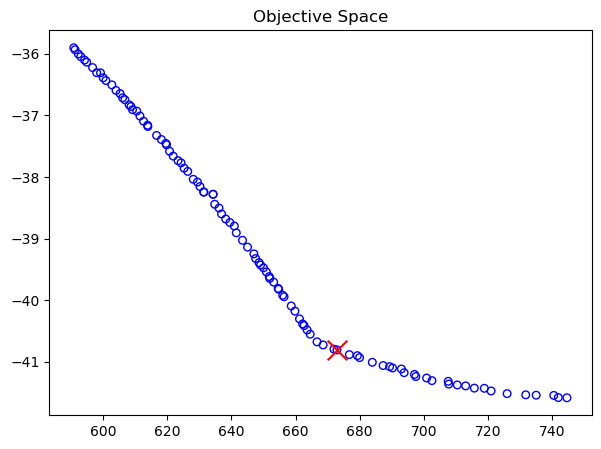

In [293]:
print("Best regarding ASF: Point \ni = %s\nF = %s" % (i, F[i]))

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(F[i, 0], F[i, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.show()

In [294]:
# Pseudo Weights

In [295]:
from pymoo.mcdm.pseudo_weights import PseudoWeights

i = PseudoWeights(weights).do(nF)



Best regarding Pseudo Weights: Point 
i = 79
F = [707.71316018 -41.36458738]


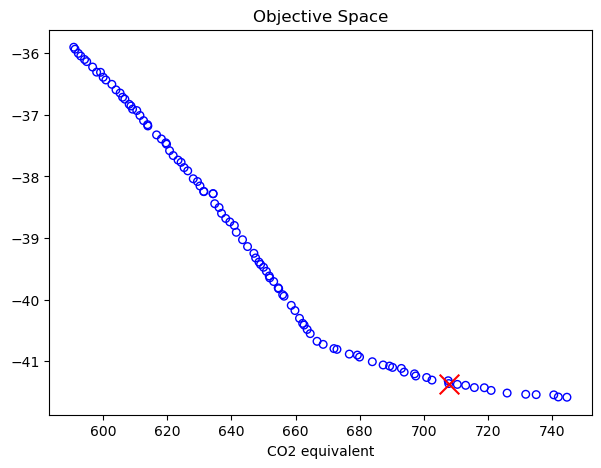

In [296]:
print("Best regarding Pseudo Weights: Point \ni = %s\nF = %s" % (i, F[i]))

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(F[i, 0], F[i, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.xlabel("CO2 equivalent")
plt.ylabel("")
plt.show()



In [297]:
# Analysis of convergence

In [298]:
X[95,:]

array([6.26033635e+01, 2.35335203e+01, 6.58803121e+00, 7.27505360e+00,
       1.00000000e+00, 2.50000000e+01, 3.85000000e+02, 6.80729623e-01,
       1.35473632e+00, 6.72267674e-02, 3.73696286e-02, 2.99844522e+01,
       5.56078505e+00, 1.60924140e-02])

In [299]:
x_test = np.array(X[0,:])

In [300]:
x_CEM1_OPC = np.array([70.19, 10.12, 8.05,8.49,1,25,385,0.4,3.2,0,0,0,0,0])
#x_CEM1_OPC = pd.DataFrame(x_CEM1_OPC)#.T, columns = initial_points.columns)
#x_CEM1_OPC = x_CEM1_OPC.T

In [301]:
#x_CEM1_OPC.columns = ['C3S', 'C2S', 'C3A', 'C4AF', 'RH', 'T', 'fineness', 'wc', 'CSH2',
       'limestone', 'silica_fume', 'GGBFS', 'fly_ash', 'calcined_clay']

IndentationError: unexpected indent (262695375.py, line 2)

In [302]:
x_CEM1_OPC

array([ 70.19,  10.12,   8.05,   8.49,   1.  ,  25.  , 385.  ,   0.4 ,
         3.2 ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ])

In [303]:
initial_points.columns

Index(['C3S', 'C2S', 'C3A', 'C4AF', 'RH', 'T', 'fineness', 'wc', 'CSH2',
       'limestone', 'silica_fume', 'GGBFS', 'fly_ash', 'calcined_clay'],
      dtype='object')

In [304]:
co2_emission_fct(x_CEM1_OPC)

0.85

In [305]:
co2_emission_fct(x_test)

0.7445538997833627

In [306]:
elasticity(x_test)

array([[26.2126458 , 11.52929442, 30.15511836,  0.30550136]])

In [307]:
elasticity(x_CEM1_OPC)

array([[32.27236828, 13.62794755, 35.83743054,  0.31463956]])